In [ ]:
#FasterR-CNN_vs_RetinaNet

In [34]:
import os, shutil, pathlib
import json
import keras
from keras import ops
import keras_hub
import numpy as np
import math

In [35]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from matplotlib.patches import Rectangle

color_map = {0: "gray"}

def label_to_color(label):
    if label not in color_map:
        h, s, v = (len(color_map) * 0.618) % 1, 0.5, 0.9
        color_map[label] = hsv_to_rgb((h, s, v))
    return color_map[label]

def draw_box(ax, box, text, color):
    x, y, w, h = box
    ax.add_patch(Rectangle((x, y), w, h, lw=2, ec=color, fc="none"))
    textbox = dict(fc=color, pad=1, ec="none")
    ax.text(x, y, text, c="white", size=10, va="bottom", bbox=textbox)

def draw_image(ax, image):
    ax.set(xlim=(0, 1), ylim=(1, 0), xticks=[], yticks=[], aspect="equal")
    image = plt.imread(image)
    height, width = image.shape[:2]
    hpad = (1 - height / width) / 2 if width > height else 0
    wpad = (1 - width / height) / 2 if height > width else 0
    extent = [wpad, 1 - wpad, 1 - hpad, hpad]
    ax.imshow(image, extent=extent)

In [36]:
from PIL import Image  # Pillow (PIL) is used by Keras' load_img
# Raise the pixel limit (None = unlimited; or set to e.g., 500000000 for safety)
Image.MAX_IMAGE_PIXELS = None

# Now load the image
path = "A_Sunday_on_La_Grande_Jatte_Georges_Seurat_1884.jpg"
image = np.array([keras.utils.load_img(path)])  # Loads as RGB array, batched in list

print(f"Image shape: {image.shape}")

Image shape: (1, 13313, 20000, 3)


In [37]:
detector = keras_hub.models.ObjectDetector.from_preset(
    "retinanet_resnet50_fpn_v2_coco",
    bounding_box_format="rel_xywh",
)
predictions_rn = detector.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


In [38]:
[(k, v.shape) for k, v in predictions_rn.items()]

[('boxes', (1, 100, 4)),
 ('confidence', (1, 100)),
 ('labels', (1, 100)),
 ('num_detections', (1,))]

In [39]:
predictions_rn["boxes"][0][0]

array([0.52832705, 0.4137052 , 0.10499302, 0.03937538], dtype=float32)

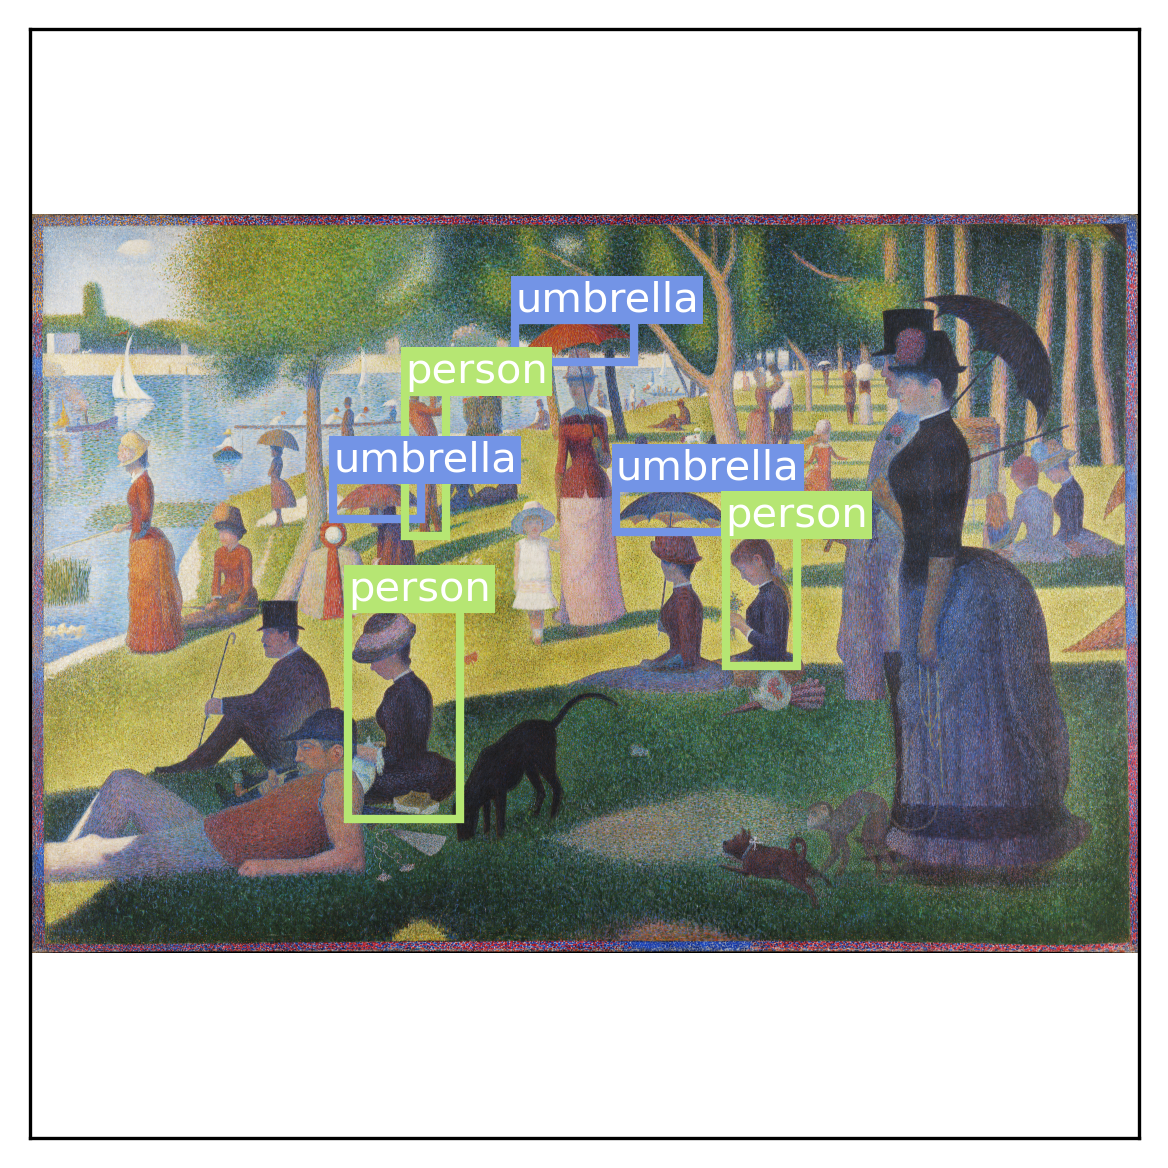

In [40]:
import collections

ig, ax = plt.subplots(dpi=300)
draw_image(ax, path)
label_counts = collections.Counter()
for i in range(predictions_rn["num_detections"][0]):
    box = predictions_rn["boxes"][0][i]
    label = predictions_rn["labels"][0][i]
    label_name = keras_hub.utils.coco_id_to_name(label)
    draw_box(ax, box, label_name, label_to_color(label))
    label_counts[label_name] += 1
plt.show()

In [41]:
# Get total detections
total_detections_rn = int(predictions_rn["num_detections"][0])
# Now printing the Result
summary_rn = ", ".join([f"{name}-{count}" for name, count in label_counts.items()])
print(f"Result of Retina_Net: Total detection: {total_detections_rn} items. {summary_rn}")

Result of Retina_Net: Total detection: 6 items. umbrella-3, person-3


In [42]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from PIL import Image
import collections
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import numpy as np

In [43]:
# Raise Pillow limit if needed (from earlier fix)
from PIL import Image as PILImage
PILImage.MAX_IMAGE_PIXELS = None

image = Image.open(path).convert("RGB")

# Preprocessing transform (COCO standard: resize, normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
])

img_tensor = transform(image).unsqueeze(0)  # Add batch dim

In [44]:
# Load model
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model = model.eval()  # Inference mode

In [45]:
# Run inference
with torch.no_grad():
    predictions = model(img_tensor)

# Extract predictions (for single image, batch=0)
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

# Total detections (post-threshold)
total_detections_fr = len(labels)
print(f"Total detections (Faster R-CNN): {total_detections_fr}")

Total detections (Faster R-CNN): 26


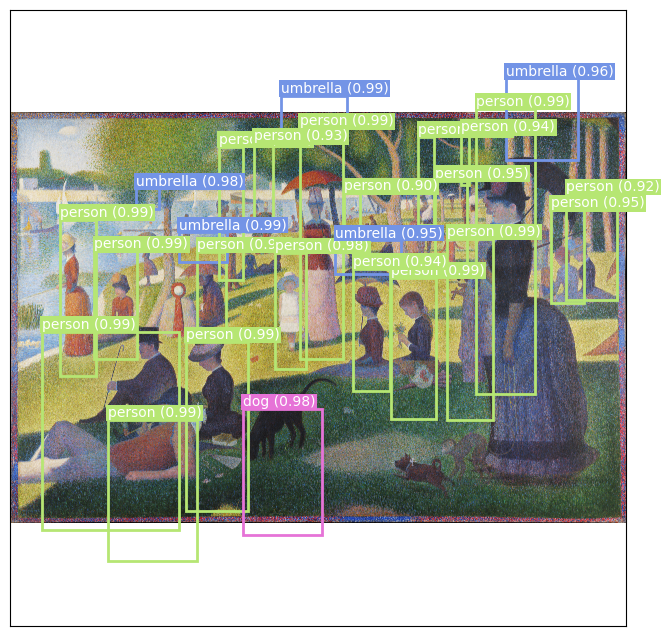

In [46]:
label_counts_fr = collections.Counter()
# Visualize (normalize boxes to [0,1] for draw_box)
fig, ax = plt.subplots(1, figsize=(12, 8))
draw_image(ax, path)  # Use path for plt.imread

for i in range(total_detections):
    box_abs = boxes[i].cpu().numpy()  # [x1,y1,x2,y2]
    label_id = int(labels[i].cpu().numpy())
    label_name = keras_hub.utils.coco_id_to_name(label_id)
    label_counts_fr[label_name] += 1
    score = scores[i].cpu().numpy()
    
    # Normalize to [0,1]: divide by image size
    h_img, w_img = image.size[1], image.size[0]  # PIL: (w,h)
    x1, y1, x2, y2 = box_abs
    x_norm = x1 / w_img
    y_norm = y1 / h_img
    w_norm = (x2 - x1) / w_img
    h_norm = (y2 - y1) / h_img
    norm_box = [x_norm, y_norm, w_norm, h_norm]
    
    color = label_to_color(label_id)  # Use label_id as key
    draw_box(ax, norm_box, f"{label_name} ({score:.2f})", color)

plt.show()

In [49]:
# Now printing the Result of Faster R-CNN
summary_fr = ", ".join([f"{name}-{count}" for name, count in label_counts_fr.items()])
print(f"Result of FasterR_CNN: Total detection: {total_detections_fr} items. {summary_fr}")

Result of FasterR_CNN: Total detection: 26 items. person-20, umbrella-5, dog-1


In [50]:
# Comparison to previous (Faster R-CNN or KerasHub)
print(f"\nComparison:")
print(f"Faster R-CNN: {total_detections_fr} items ({summary_fr})")
print(f"RetinaNet: {total_detections_rn} items ({summary_rn})")


Comparison:
Faster R-CNN: 26 items (person-20, umbrella-5, dog-1)
RetinaNet: 6 items (umbrella-3, person-3)
